In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
import plotly.express as px

In [3]:
df=pd.read_csv('ml_data.csv')
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
944463,575312,22083,PAPER CHAIN KIT RETROSPOT,6,2011-11-09 12:49:00,2.95,13588.0,United Kingdom
944464,575312,23355,HOT WATER BOTTLE KEEP CALM,4,2011-11-09 12:49:00,4.95,13588.0,United Kingdom
944465,575312,22110,BIRD HOUSE HOT WATER BOTTLE,6,2011-11-09 12:49:00,2.55,13588.0,United Kingdom
944466,575312,22037,ROBOT BIRTHDAY CARD,12,2011-11-09 12:49:00,0.42,13588.0,United Kingdom


### Null Treatment

In [4]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4194
Quantity            0
InvoiceDate         0
Price               0
Customer ID    211901
Country             0
dtype: int64

In [5]:
# Since prediction will be for customer ids, removing records having no customer ID values
df2=df[df['Customer ID'].notna()].reset_index().drop('index',axis=1)
df2

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
732562,575312,22083,PAPER CHAIN KIT RETROSPOT,6,2011-11-09 12:49:00,2.95,13588.0,United Kingdom
732563,575312,23355,HOT WATER BOTTLE KEEP CALM,4,2011-11-09 12:49:00,4.95,13588.0,United Kingdom
732564,575312,22110,BIRD HOUSE HOT WATER BOTTLE,6,2011-11-09 12:49:00,2.55,13588.0,United Kingdom
732565,575312,22037,ROBOT BIRTHDAY CARD,12,2011-11-09 12:49:00,0.42,13588.0,United Kingdom


In [6]:
df2.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

### Data Preprocessing

In [7]:
#Check for if any Customer ID has decimal values other than 0

# df3=df2.copy()
# df3['dummy']=df3['Customer ID']
# df3['dummy']=df3['dummy'].astype(int)
# df3
# df3[df3['Customer ID']>df3.dummy]

In [8]:
#Changing data type of Customer ID to string

df2['Customer ID']=df2['Customer ID'].astype(int)
df2['Customer ID']=df2['Customer ID'].astype(str)

df2['InvoiceDate']=pd.to_datetime(df2['InvoiceDate'])
df2.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [9]:
# Statistical summary of numerical data - understanding data ranges 
df2.describe()

,Quantity,Price
count,732567.000000,732567.000000
mean,12.792626,3.766560
std,147.626721,74.355886
min,-74215.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,74215.000000,38970.000000


In [10]:
# Understanding reason behind negative values of price - if cancelled orders only have negative quantity
x=df2[df2.Invoice.str.contains('C')]
print(len(x[x.Quantity<0]),len(x))
y=df2[df2.Quantity>=0]
y[y.Invoice.str.contains('C')]

17341 17341


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [11]:
# Getting net Customer Spend : Calculate Price * Quantity for every Record
df2['Net_Cust_Spend']=df2['Price']*df2['Quantity']
df2['Net_Cust_Spend_mod']=np.where(df2['Net_Cust_Spend'] <0,0,df2['Net_Cust_Spend'])
df2

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Net_Cust_Spend,Net_Cust_Spend_mod
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00,30.00
...,...,...,...,...,...,...,...,...,...,...
732562,575312,22083,PAPER CHAIN KIT RETROSPOT,6,2011-11-09 12:49:00,2.95,13588,United Kingdom,17.70,17.70
732563,575312,23355,HOT WATER BOTTLE KEEP CALM,4,2011-11-09 12:49:00,4.95,13588,United Kingdom,19.80,19.80
732564,575312,22110,BIRD HOUSE HOT WATER BOTTLE,6,2011-11-09 12:49:00,2.55,13588,United Kingdom,15.30,15.30
732565,575312,22037,ROBOT BIRTHDAY CARD,12,2011-11-09 12:49:00,0.42,13588,United Kingdom,5.04,5.04


## ADS preparation

In [12]:
# dataframe split based on time
## ADS (Modelling) : 2009-12-01 to 2011-10-09
## Test Set : 2011-10-10 to 2011-11-09

#filtering for records beyond 1 month of max InvoiceDate value present in dataset
th_dt=datetime.strptime('2011-11-09',"%Y-%m-%d")+pd.Timedelta(days=-30)
ads_df=df2[df2.InvoiceDate<th_dt]
ads_df

#Get max InvoiceDate for every customer in unfiltered data
cust_invdt_ttl=df2.groupby(['Customer ID'],as_index=False).agg({'InvoiceDate':'max'}).rename({
    'InvoiceDate':'InvoiceDate_max'},axis=1)
cust_invdt_ttl

#Get common customers in modelling ADS and unfiltered data
ads=pd.DataFrame({'Customer ID':list(ads_df['Customer ID'].unique())})
ads=pd.merge(ads,cust_invdt_ttl,how='left',on='Customer ID')
ads

#Check for customers buying products within 2011-10-10 and 2011-11-09, flag them as 1, rest as 0 -> target column
ads['next_mnth_prchse']=np.where((ads['InvoiceDate_max']>=th_dt),1,0)
ads=ads[['Customer ID','next_mnth_prchse']]
ads

,Customer ID,next_mnth_prchse
0,13085,0
1,13078,1
2,15362,0
3,18102,1
4,12682,1
...,...,...
5567,16685,0
5568,13193,0
5569,13212,0
5570,14801,0


In [13]:
# Distribution of target column - class imbalance found
ads['next_mnth_prchse'].value_counts()

0    4263
1    1309
Name: next_mnth_prchse, dtype: int64

In [67]:
dist_df=ads.groupby(['next_mnth_prchse'],as_index=False).size().rename({'size':'count_class'},axis=1)
dist_df['pct_count']=np.round(dist_df['count_class']*100/len(ads),2)
dist_df['pct_count']=dist_df['pct_count'].apply(lambda x:str(x)+' %')
dist_df
bar=px.bar(dist_df,x='next_mnth_prchse',y='count_class',text='pct_count',title='Target Value Distribution')
bar.show()

### Calculating RFM values to understand proirity of customers for the store

In [15]:
# Recency - R
## logic : For every customer Id - Calculate difference in days between 2011-10-09 and their last purchase date
ads_cust_invdt=ads_df.groupby(['Customer ID'],as_index=False).agg({'InvoiceDate':'max'}).rename({
    'InvoiceDate':'InvoiceDate_max'},axis=1)
ads_cust_invdt['Max_dt']=th_dt+pd.Timedelta(days=-1)
ads_cust_invdt['Recency']=(ads_cust_invdt['Max_dt']-ads_cust_invdt['InvoiceDate_max']).dt.days

# Since only dates are subtracted and time isnt considered here, matching max_dt and InvoiceDate_max values 
# will have diff < 0. So they are replaced by 0 Due to match in Date
ads_cust_invdt['Recency']=np.where(ads_cust_invdt['Recency']<0,0,ads_cust_invdt['Recency'])
ads_cust_invdt=ads_cust_invdt[['Customer ID','Recency']]

# Add Recency to main ads
ads=pd.merge(ads_cust_invdt,ads,how='inner',on='Customer ID')
ads

,Customer ID,Recency,next_mnth_prchse
0,12346,263,0
1,12347,67,1
2,12348,13,0
3,12349,345,0
4,12350,248,0
...,...,...,...
5567,18283,33,1
5568,18284,367,0
5569,18285,598,0
5570,18286,414,0


In [16]:
# Frequency - F
## Logic : For every Customer ID, get count of distrinct InvoiceDate values
ads_freq=ads_df.groupby(['Customer ID'],as_index=False).agg({'InvoiceDate':'nunique'}).rename({
    'InvoiceDate':'Frequency'},axis=1)

# Adding Frequency data to main ads
ads=pd.merge(ads_freq,ads,how='inner',on='Customer ID')
ads

,Customer ID,Frequency,Recency,next_mnth_prchse
0,12346,17,263,0
1,12347,6,67,1
2,12348,5,13,0
3,12349,4,345,0
4,12350,1,248,0
...,...,...,...,...
5567,18283,16,33,1
5568,18284,2,367,0
5569,18285,1,598,0
5570,18286,3,414,0


In [17]:
# Monetary Value / Revenue - M
## Logic : For every Customer ID, get sum of entire Net_Cust_Spend
ads_rev=ads_df.groupby(['Customer ID'],as_index=False).agg({'Net_Cust_Spend_mod':'sum'}).rename({
    'Net_Cust_Spend_mod':'Totl_Money_Spent'},axis=1)

# Add Monetary value to main ads
ads=pd.merge(ads_rev,ads,how='inner',on='Customer ID')
ads

,Customer ID,Totl_Money_Spent,Frequency,Recency,next_mnth_prchse
0,12346,77556.46,17,263,0
1,12347,3402.39,6,67,1
2,12348,2019.40,5,13,0
3,12349,2671.14,4,345,0
4,12350,334.40,1,248,0
...,...,...,...,...,...
5567,18283,1706.20,16,33,1
5568,18284,461.68,2,367,0
5569,18285,427.00,1,598,0
5570,18286,1296.43,3,414,0


In [18]:
# Checking distribution of R,F,M values to understand data spread and range
ads[['Totl_Money_Spent','Frequency','Recency']].describe()

,Totl_Money_Spent,Frequency,Recency
count,5572.000000,5572.000000,5572.000000
mean,2687.265253,7.003410,205.079684
std,13033.889368,14.503232,189.960525
min,0.000000,1.000000,0.000000
25%,313.635000,1.000000,30.000000
50%,776.730000,3.000000,144.000000
75%,2099.940000,7.250000,344.000000
max,524476.600000,431.000000,676.000000


In [19]:
#Transformation of RFM values
ads['Totl_Money_Spent_trf']=(ads['Totl_Money_Spent']-ads['Totl_Money_Spent'].min())/(ads['Totl_Money_Spent'].max()
                                                                                     -ads['Totl_Money_Spent'].min())
ads['Frequency_trf']=(ads['Frequency']-ads['Frequency'].min())/(ads['Frequency'].max()-ads['Frequency'].min())
ads['Recency_trf']=(ads['Recency']-ads['Recency'].min())/(ads['Recency'].max()-ads['Recency'].min())
ads

,Customer ID,Totl_Money_Spent,Frequency,Recency,next_mnth_prchse,Totl_Money_Spent_trf,Frequency_trf,Recency_trf
0,12346,77556.46,17,263,0,0.147874,0.037209,0.389053
1,12347,3402.39,6,67,1,0.006487,0.011628,0.099112
2,12348,2019.40,5,13,0,0.003850,0.009302,0.019231
3,12349,2671.14,4,345,0,0.005093,0.006977,0.510355
4,12350,334.40,1,248,0,0.000638,0.000000,0.366864
...,...,...,...,...,...,...,...,...
5567,18283,1706.20,16,33,1,0.003253,0.034884,0.048817
5568,18284,461.68,2,367,0,0.000880,0.002326,0.542899
5569,18285,427.00,1,598,0,0.000814,0.000000,0.884615
5570,18286,1296.43,3,414,0,0.002472,0.004651,0.612426


In [20]:
ads[['Totl_Money_Spent_trf','Frequency_trf','Recency_trf']].describe()

,Totl_Money_Spent_trf,Frequency_trf,Recency_trf
count,5572.000000,5572.000000,5572.000000
mean,0.005124,0.013961,0.303372
std,0.024851,0.033728,0.281007
min,0.000000,0.000000,0.000000
25%,0.000598,0.000000,0.044379
50%,0.001481,0.004651,0.213018
75%,0.004004,0.014535,0.508876
max,1.000000,1.000000,1.000000


### RFM Scores

Based on distribution of transformed values, R,F,M are scored using ntile function:
- Recency - 3 buckets
- Frequency - 3 buckets
- Totl_Money_Spent - 3 buckets

High values of bucket will indicate high score for the corresponding factor

In [21]:
# Getting Recency scores
ads['Recency_Score']=pd.qcut(ads['Recency_trf'],q=4,labels=[4,3,2,1])
ads

,Customer ID,Totl_Money_Spent,Frequency,Recency,next_mnth_prchse,Totl_Money_Spent_trf,Frequency_trf,Recency_trf,Recency_Score
0,12346,77556.46,17,263,0,0.147874,0.037209,0.389053,2
1,12347,3402.39,6,67,1,0.006487,0.011628,0.099112,3
2,12348,2019.40,5,13,0,0.003850,0.009302,0.019231,4
3,12349,2671.14,4,345,0,0.005093,0.006977,0.510355,1
4,12350,334.40,1,248,0,0.000638,0.000000,0.366864,2
...,...,...,...,...,...,...,...,...,...
5567,18283,1706.20,16,33,1,0.003253,0.034884,0.048817,3
5568,18284,461.68,2,367,0,0.000880,0.002326,0.542899,1
5569,18285,427.00,1,598,0,0.000814,0.000000,0.884615,1
5570,18286,1296.43,3,414,0,0.002472,0.004651,0.612426,1


In [22]:
# Getting Frequency scores
ads['Frequency_Score']=pd.qcut(ads['Frequency_trf'].rank(method='first'),q=4,labels=[1,2,3,4])
ads

,Customer ID,Totl_Money_Spent,Frequency,Recency,next_mnth_prchse,Totl_Money_Spent_trf,Frequency_trf,Recency_trf,Recency_Score,Frequency_Score
0,12346,77556.46,17,263,0,0.147874,0.037209,0.389053,2,4
1,12347,3402.39,6,67,1,0.006487,0.011628,0.099112,3,3
2,12348,2019.40,5,13,0,0.003850,0.009302,0.019231,4,3
3,12349,2671.14,4,345,0,0.005093,0.006977,0.510355,1,3
4,12350,334.40,1,248,0,0.000638,0.000000,0.366864,2,1
...,...,...,...,...,...,...,...,...,...,...
5567,18283,1706.20,16,33,1,0.003253,0.034884,0.048817,3,4
5568,18284,461.68,2,367,0,0.000880,0.002326,0.542899,1,2
5569,18285,427.00,1,598,0,0.000814,0.000000,0.884615,1,2
5570,18286,1296.43,3,414,0,0.002472,0.004651,0.612426,1,3


In [23]:
# Getting Revenue scores
ads['Totl_Money_Spent_Score']=pd.qcut(ads['Totl_Money_Spent_trf'],q=4,labels=[1,2,3,4])
ads

,Customer ID,Totl_Money_Spent,Frequency,Recency,next_mnth_prchse,Totl_Money_Spent_trf,Frequency_trf,Recency_trf,Recency_Score,Frequency_Score,Totl_Money_Spent_Score
0,12346,77556.46,17,263,0,0.147874,0.037209,0.389053,2,4,4
1,12347,3402.39,6,67,1,0.006487,0.011628,0.099112,3,3,4
2,12348,2019.40,5,13,0,0.003850,0.009302,0.019231,4,3,3
3,12349,2671.14,4,345,0,0.005093,0.006977,0.510355,1,3,4
4,12350,334.40,1,248,0,0.000638,0.000000,0.366864,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...
5567,18283,1706.20,16,33,1,0.003253,0.034884,0.048817,3,4,3
5568,18284,461.68,2,367,0,0.000880,0.002326,0.542899,1,2,2
5569,18285,427.00,1,598,0,0.000814,0.000000,0.884615,1,2,2
5570,18286,1296.43,3,414,0,0.002472,0.004651,0.612426,1,3,3


### Weighted RFM scoring

Based on Business Lookout,since target is to predict customers who will buy any product next month, the descending order of priority for R,F,M metrics has been selected as -
- Frequency (F) > Revenue (M) > Recency (R)

Therefore, out of 100% contribution towards target variable, the following weights have been assigned to the RFM metrics :
- Frequency : 50% (0.5)
- Revenue : 30% (0.3)
- Recency : 20% (0.2)

In [24]:
# Multiply weights with RFM scores
ads['w_Recency_Score']=ads['Recency_Score'].astype(int)*0.2
ads['w_Frequency_Score']=ads['Frequency_Score'].astype(int)*0.5
ads['w_Totl_Money_Spent_Score']=ads['Totl_Money_Spent_Score'].astype(int)*0.3
ads

,Customer ID,Totl_Money_Spent,Frequency,Recency,next_mnth_prchse,Totl_Money_Spent_trf,Frequency_trf,Recency_trf,Recency_Score,Frequency_Score,Totl_Money_Spent_Score,w_Recency_Score,w_Frequency_Score,w_Totl_Money_Spent_Score
0,12346,77556.46,17,263,0,0.147874,0.037209,0.389053,2,4,4,0.4,2.0,1.2
1,12347,3402.39,6,67,1,0.006487,0.011628,0.099112,3,3,4,0.6,1.5,1.2
2,12348,2019.40,5,13,0,0.003850,0.009302,0.019231,4,3,3,0.8,1.5,0.9
3,12349,2671.14,4,345,0,0.005093,0.006977,0.510355,1,3,4,0.2,1.5,1.2
4,12350,334.40,1,248,0,0.000638,0.000000,0.366864,2,1,2,0.4,0.5,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,18283,1706.20,16,33,1,0.003253,0.034884,0.048817,3,4,3,0.6,2.0,0.9
5568,18284,461.68,2,367,0,0.000880,0.002326,0.542899,1,2,2,0.2,1.0,0.6
5569,18285,427.00,1,598,0,0.000814,0.000000,0.884615,1,2,2,0.2,1.0,0.6
5570,18286,1296.43,3,414,0,0.002472,0.004651,0.612426,1,3,3,0.2,1.5,0.9


In [25]:
# Calculating Net score for all RFM scores combined
ads['Net_RFM_Score']=ads['w_Recency_Score']+ads['w_Frequency_Score']+ads['w_Totl_Money_Spent_Score']
ads

,Customer ID,Totl_Money_Spent,Frequency,Recency,next_mnth_prchse,Totl_Money_Spent_trf,Frequency_trf,Recency_trf,Recency_Score,Frequency_Score,Totl_Money_Spent_Score,w_Recency_Score,w_Frequency_Score,w_Totl_Money_Spent_Score,Net_RFM_Score
0,12346,77556.46,17,263,0,0.147874,0.037209,0.389053,2,4,4,0.4,2.0,1.2,3.6
1,12347,3402.39,6,67,1,0.006487,0.011628,0.099112,3,3,4,0.6,1.5,1.2,3.3
2,12348,2019.40,5,13,0,0.003850,0.009302,0.019231,4,3,3,0.8,1.5,0.9,3.2
3,12349,2671.14,4,345,0,0.005093,0.006977,0.510355,1,3,4,0.2,1.5,1.2,2.9
4,12350,334.40,1,248,0,0.000638,0.000000,0.366864,2,1,2,0.4,0.5,0.6,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,18283,1706.20,16,33,1,0.003253,0.034884,0.048817,3,4,3,0.6,2.0,0.9,3.5
5568,18284,461.68,2,367,0,0.000880,0.002326,0.542899,1,2,2,0.2,1.0,0.6,1.8
5569,18285,427.00,1,598,0,0.000814,0.000000,0.884615,1,2,2,0.2,1.0,0.6,1.8
5570,18286,1296.43,3,414,0,0.002472,0.004651,0.612426,1,3,3,0.2,1.5,0.9,2.6


In [26]:
ads_final=ads[['Customer ID','Net_RFM_Score','next_mnth_prchse']]
ads_final

,Customer ID,Net_RFM_Score,next_mnth_prchse
0,12346,3.6,0
1,12347,3.3,1
2,12348,3.2,0
3,12349,2.9,0
4,12350,1.5,0
...,...,...,...
5567,18283,3.5,1
5568,18284,1.8,0
5569,18285,1.8,0
5570,18286,2.6,0


## Modelling Pipeline

In [27]:
# Split into train and valid set
Y=ads_final[['next_mnth_prchse']]
X=ads_final.drop('next_mnth_prchse',axis=1)
x_train,x_valid,y_train,y_valid=train_test_split(X,Y,test_size=0.3, stratify=Y)
x_train

,Customer ID,Net_RFM_Score
4667,17311,3.5
3642,16231,2.8
5114,17787,3.0
1652,14109,1.6
4682,17327,1.5
...,...,...
4428,17058,3.2
3906,16511,3.0
2182,14671,2.1
2735,15258,2.2


In [28]:
# Removing Customer ID from train and valid data
x_train_mod=x_train.drop('Customer ID',axis=1)
x_valid_mod=x_valid.drop('Customer ID',axis=1)

In [29]:
# # Checking for multicollinearity
# vif_df = pd.DataFrame()
# vif_df["feature"] = x_train_vif.columns
  
# # calculating VIF for each feature
# vif_df["VIF"] = [vif(x_train_vif.values, i)
#                           for i in range(len(x_train_vif.columns))]

# vif_df

### Logistic Regression

In [30]:
# Initializing logistic regression
classifier_lr = LogisticRegression(random_state=300,multi_class='ovr')
classifier_lr.fit(x_train_mod, y_train)

LogisticRegression(multi_class='ovr', random_state=300)

In [31]:
#Predictions for logistic regression and buy-probability calculation - valid set
y_pred_valid_lr = classifier_lr.predict(x_valid_mod)
y_pred_valid_lr=pd.Series(y_pred_valid_lr)
pred_valid_prob_lr=classifier_lr.predict_proba(x_valid_mod)[:, 1]

In [32]:
#Predictions for logistic regression and buy-probability calculation - train set
y_pred_train_lr = classifier_lr.predict(x_train_mod)
y_pred_train_lr=pd.Series(y_pred_train_lr)

In [33]:
def model_performance(y_test,y_pred,opt):
    # Accuracy Score
    print ("Accuracy ",opt," : ", accuracy_score(y_test, y_pred),'\n')
        
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['won"t buy(0)','will buy(1)'])
    ax.yaxis.set_ticklabels(['won"t buy(0)','will buy(1)'])
    
    # Classification report
    target_names = ['wont buy(0)', 'will buy(1)']
    print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy  valid set  :  0.7828947368421053 

              precision    recall  f1-score   support

 wont buy(0)       0.81      0.94      0.87      1279
 will buy(1)       0.58      0.27      0.37       393

    accuracy                           0.78      1672
   macro avg       0.70      0.60      0.62      1672
weighted avg       0.75      0.78      0.75      1672



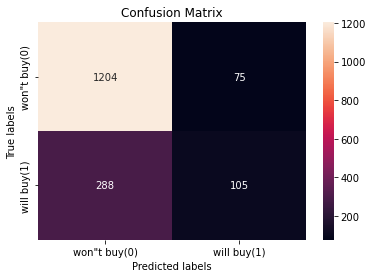

In [34]:
model_performance(y_valid,y_pred_valid_lr,'valid set')

Accuracy  train set  :  0.7923076923076923 

              precision    recall  f1-score   support

 wont buy(0)       0.81      0.95      0.87      2984
 will buy(1)       0.62      0.29      0.40       916

    accuracy                           0.79      3900
   macro avg       0.72      0.62      0.64      3900
weighted avg       0.77      0.79      0.76      3900



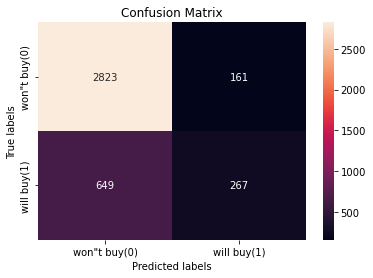

In [35]:
model_performance(y_train,y_pred_train_lr,'train set')

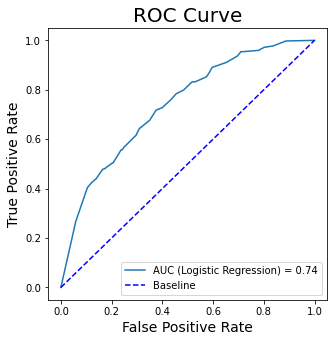

In [36]:
# ROC-AUC
auc_lr = roc_auc_score(y_valid, pred_valid_prob_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_valid, pred_valid_prob_lr)

plt.figure(figsize=(5, 5))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()

### KNN Classifier

In [37]:
rec_c1 = []
target_names = ['wont buy(0)', 'will buy(1)']
for i in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train_mod, y_train)
    yhat = neigh.predict(x_valid_mod)
    cr=classification_report(y_valid, yhat, target_names=target_names,output_dict=True)
    rec_c1.append(cr['will buy(1)']['recall'])
    
print("Maximum recall of class 1 :-",max(rec_c1),"at K =",rec_c1.index(max(rec_c1))+1)

Maximum recall of class 1 :- 0.37404580152671757 at K = 3


In [38]:
k=rec_c1.index(max(rec_c1))+1
classifier_knn = KNeighborsClassifier(n_neighbors = k).fit(x_train_mod, y_train)

In [39]:
#Predictions for logistic regression and buy-probability calculation - valid set
y_pred_valid_knn = classifier_knn.predict(x_valid_mod)
y_pred_valid_knn=pd.Series(y_pred_valid_knn)
pred_valid_prob_knn=classifier_knn.predict_proba(x_valid_mod)[:, 1]

In [40]:
#Predictions for logistic regression and buy-probability calculation - train set
y_pred_train_knn = classifier_knn.predict(x_train_mod)
y_pred_train_knn=pd.Series(y_pred_train_knn)

Accuracy  valid set  :  0.743421052631579 

              precision    recall  f1-score   support

 wont buy(0)       0.82      0.86      0.84      1279
 will buy(1)       0.45      0.37      0.41       393

    accuracy                           0.74      1672
   macro avg       0.63      0.62      0.62      1672
weighted avg       0.73      0.74      0.74      1672



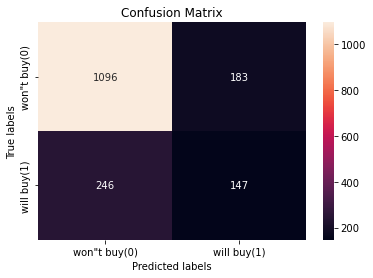

In [64]:
model_performance(y_valid,y_pred_valid_knn,'valid set')

Accuracy  train set  :  0.7576923076923077 

              precision    recall  f1-score   support

 wont buy(0)       0.82      0.87      0.85      2984
 will buy(1)       0.48      0.39      0.43       916

    accuracy                           0.76      3900
   macro avg       0.65      0.63      0.64      3900
weighted avg       0.74      0.76      0.75      3900



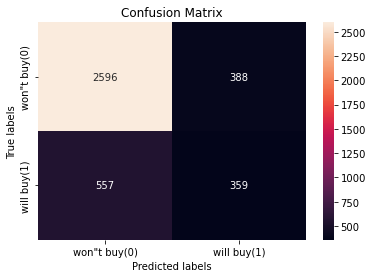

In [65]:
model_performance(y_train,y_pred_train_knn,'train set')

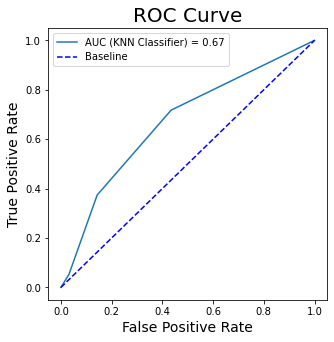

In [43]:
# ROC-AUC
auc_knn = roc_auc_score(y_valid, pred_valid_prob_knn)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_valid, pred_valid_prob_knn)

plt.figure(figsize=(5, 5))
plt.plot(fpr_knn, tpr_knn, label=f'AUC (KNN Classifier) = {auc_knn:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()

Since the target of business is to capture potential customers who can buy products in the next month, the results produced above cannot be utilized since none of the models are able to capture class 1(will buy) better. This can be due to the fact that the dataset is imbalanced, which can be rectified using SMOTE.

## Restructured Modelling Pipeline with SMOTE application

In [44]:
# Making a copy of final ADS
X_2=X.copy()
Y_2=Y.copy()
X_2=X_2.drop('Customer ID',axis=1)

# Increase occurances of class 1
ov_sp=SMOTE()
ov_X,ov_Y=ov_sp.fit_resample(X_2, Y_2)

#train-valid data split
ov_x_train, ov_x_valid, ov_y_train, ov_y_valid = train_test_split(ov_X, ov_Y, test_size=0.3, stratify=ov_Y)
ov_x_train

,Net_RFM_Score
4338,1.5
7183,3.3
5363,1.7
2596,1.0
7109,3.2
...,...
395,3.8
4059,2.4
3295,3.2
1308,2.5


### SMOTE Logistic Regression Classifier

In [45]:
# Initializing logistic regression
smote_classifier_lr = LogisticRegression(random_state=300,multi_class='ovr')
smote_classifier_lr.fit(ov_x_train,ov_y_train)

LogisticRegression(multi_class='ovr', random_state=300)

In [46]:
# apply smote rf model to predict for non-smote valid set
y_pred_valid_lrsmote=smote_classifier_lr.predict(x_valid_mod)
y_pred_valid_lrsmote=pd.Series(y_pred_valid_lrsmote)
pred_valid_prob_lrsmote=smote_classifier_lr.predict_proba(x_valid_mod)[:, 1]

In [47]:
# apply smote rf model to predict for non-smote train set
y_pred_train_lrsmote=smote_classifier_lr.predict(x_train_mod)
y_pred_train_lrsmote=pd.Series(y_pred_train_lrsmote)

Accuracy  valid set  :  0.6561004784688995 

              precision    recall  f1-score   support

 wont buy(0)       0.87      0.65      0.74      1279
 will buy(1)       0.37      0.68      0.48       393

    accuracy                           0.66      1672
   macro avg       0.62      0.66      0.61      1672
weighted avg       0.75      0.66      0.68      1672



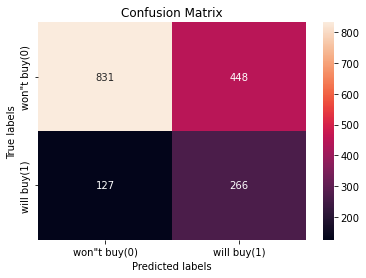

In [48]:
model_performance(y_valid,y_pred_valid_lrsmote,'valid set')

Accuracy  train set  :  0.6684615384615384 

              precision    recall  f1-score   support

 wont buy(0)       0.88      0.66      0.75      2984
 will buy(1)       0.39      0.70      0.50       916

    accuracy                           0.67      3900
   macro avg       0.63      0.68      0.63      3900
weighted avg       0.76      0.67      0.69      3900



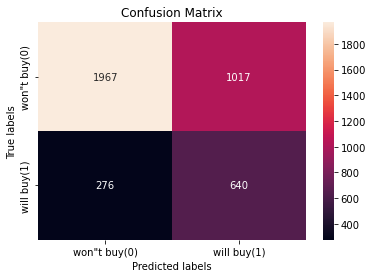

In [49]:
model_performance(y_train,y_pred_train_lrsmote,'train set')

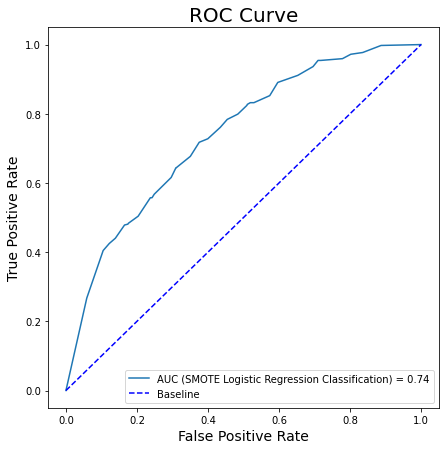

In [50]:
# ROC-AUC for Smote RF results
auc_lr = roc_auc_score(y_valid, pred_valid_prob_lrsmote)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_valid, pred_valid_prob_lrsmote)

plt.figure(figsize=(7, 7))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (SMOTE Logistic Regression Classification) = {auc_lr:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend()

-----------------------------------------------------------------------------------------------------------------------

In [51]:
#Create Stratified K-fold cross validation to validate model performance and check for variance
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=300)
scoring = ('f1', 'recall', 'precision','accuracy')
#Evaluate SMOTE RF model
scores = cross_validate(smote_classifier_lr, ov_X, ov_Y, scoring=scoring, cv=cv)
#Get average evaluation metrics

print('Mean f1: %.3f' % np.mean(scores['test_f1']))
print('Mean recall: %.3f' % np.mean(scores['test_recall']))
print('Mean precision: %.3f' % np.mean(scores['test_precision']))
print('Mean accuracy: %.3f' % np.mean(scores['test_accuracy']))

Mean f1: 0.682
Mean recall: 0.696
Mean precision: 0.669
Mean accuracy: 0.676


## Probability Prediction for customers to buy a product between 2011-11-09 to 2011-12-09

In [52]:
# Test Set Preparation : Create Dataframe of all Customer IDs till 2011-11-09
test_set=df2.groupby(['Customer ID'],as_index=False).size()
test_set=test_set[['Customer ID']]
test_set

,Customer ID
0,12346
1,12347
2,12348
3,12349
4,12350
...,...
5775,18283
5776,18284
5777,18285
5778,18286


### Calculating RFM values

In [53]:
# Calculating RFM values for test set
# Recency - R
ads_cust_invdt=df2.groupby(['Customer ID'],as_index=False).agg({'InvoiceDate':'max'}).rename({
    'InvoiceDate':'InvoiceDate_max'},axis=1)
ads_cust_invdt['Max_dt']=df2['InvoiceDate'].max()
ads_cust_invdt['Recency']=(ads_cust_invdt['Max_dt']-ads_cust_invdt['InvoiceDate_max']).dt.days

# In case of negative date difference, it will be replaced by 0
ads_cust_invdt['Recency']=np.where(ads_cust_invdt['Recency']<0,0,ads_cust_invdt['Recency'])
ads_cust_invdt=ads_cust_invdt[['Customer ID','Recency']]
ads_cust_invdt

# Add Recency to main ads
test_set=pd.merge(ads_cust_invdt,test_set,how='inner',on='Customer ID')


# Frequency - F
ads_freq=df2.groupby(['Customer ID'],as_index=False).agg({'InvoiceDate':'nunique'}).rename({
    'InvoiceDate':'Frequency'},axis=1)

# Adding Frequency data to main ads
test_set=pd.merge(ads_freq,test_set,how='inner',on='Customer ID')


# Monetary Value / Revenue - M
## Logic : For every Customer ID, get sum of entire Net_Cust_Spend
ads_rev=df2.groupby(['Customer ID'],as_index=False).agg({'Net_Cust_Spend_mod':'sum'}).rename({
    'Net_Cust_Spend_mod':'Totl_Money_Spent'},axis=1)

# Add Monetary value to main ads
test_set=pd.merge(ads_rev,test_set,how='inner',on='Customer ID')
test_set

,Customer ID,Totl_Money_Spent,Frequency,Recency
0,12346,77556.46,17,295
1,12347,4696.71,7,9
2,12348,2019.40,5,44
3,12349,2671.14,4,377
4,12350,334.40,1,279
...,...,...,...,...
5775,18283,1819.19,17,12
5776,18284,461.68,2,399
5777,18285,427.00,1,630
5778,18286,1296.43,3,446


In [54]:
# Applying data transformation on RFM values
test_set['Totl_Money_Spent_trf']=(test_set['Totl_Money_Spent']-test_set['Totl_Money_Spent'].min())/(
    test_set['Totl_Money_Spent'].max()-test_set['Totl_Money_Spent'].min())
test_set['Frequency_trf']=(test_set['Frequency']-test_set['Frequency'].min())/(test_set['Frequency'].max()-
                                                                               test_set['Frequency'].min())
test_set['Recency_trf']=(test_set['Recency']-test_set['Recency'].min())/(test_set['Recency'].max()-
                                                                         test_set['Recency'].min())
test_set

,Customer ID,Totl_Money_Spent,Frequency,Recency,Totl_Money_Spent_trf,Frequency_trf,Recency_trf
0,12346,77556.46,17,295,0.136252,0.034409,0.416667
1,12347,4696.71,7,9,0.008251,0.012903,0.012712
2,12348,2019.40,5,44,0.003548,0.008602,0.062147
3,12349,2671.14,4,377,0.004693,0.006452,0.532486
4,12350,334.40,1,279,0.000587,0.000000,0.394068
...,...,...,...,...,...,...,...
5775,18283,1819.19,17,12,0.003196,0.034409,0.016949
5776,18284,461.68,2,399,0.000811,0.002151,0.563559
5777,18285,427.00,1,630,0.000750,0.000000,0.889831
5778,18286,1296.43,3,446,0.002278,0.004301,0.629944


In [55]:
test_set.describe()

,Totl_Money_Spent,Frequency,Recency,Totl_Money_Spent_trf,Frequency_trf,Recency_trf
count,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000,5780.000000
mean,2773.135119,7.176817,203.424048,0.004872,0.013283,0.287322
std,13702.082997,15.023021,201.343859,0.024072,0.032308,0.284384
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,320.535000,1.000000,28.000000,0.000563,0.000000,0.039548
50%,810.985000,3.000000,124.500000,0.001425,0.004301,0.175847
75%,2124.025000,8.000000,362.000000,0.003731,0.015054,0.511299
max,569215.420000,466.000000,708.000000,1.000000,1.000000,1.000000


### Getting RFM scores

In [56]:
test_set['Recency_Score']=pd.qcut(test_set['Recency_trf'],q=4,labels=[4,3,2,1])
test_set['Frequency_Score']=pd.qcut(test_set['Frequency_trf'].rank(method='first'),q=4,labels=[1,2,3,4])
test_set['Totl_Money_Spent_Score']=pd.qcut(test_set['Totl_Money_Spent_trf'],q=4,labels=[1,2,3,4])
test_set

,Customer ID,Totl_Money_Spent,Frequency,Recency,Totl_Money_Spent_trf,Frequency_trf,Recency_trf,Recency_Score,Frequency_Score,Totl_Money_Spent_Score
0,12346,77556.46,17,295,0.136252,0.034409,0.416667,2,4,4
1,12347,4696.71,7,9,0.008251,0.012903,0.012712,4,3,4
2,12348,2019.40,5,44,0.003548,0.008602,0.062147,3,3,3
3,12349,2671.14,4,377,0.004693,0.006452,0.532486,1,3,4
4,12350,334.40,1,279,0.000587,0.000000,0.394068,2,1,2
...,...,...,...,...,...,...,...,...,...,...
5775,18283,1819.19,17,12,0.003196,0.034409,0.016949,4,4,3
5776,18284,461.68,2,399,0.000811,0.002151,0.563559,1,2,2
5777,18285,427.00,1,630,0.000750,0.000000,0.889831,1,2,2
5778,18286,1296.43,3,446,0.002278,0.004301,0.629944,1,3,3


### Applying weights on scores

In [57]:
test_set['w_Recency_Score']=test_set['Recency_Score'].astype(int)*0.2
test_set['w_Frequency_Score']=test_set['Frequency_Score'].astype(int)*0.5
test_set['w_Totl_Money_Spent_Score']=test_set['Totl_Money_Spent_Score'].astype(int)*0.3

test_set['Net_RFM_Score']=test_set['w_Recency_Score']+test_set['w_Frequency_Score']+test_set['w_Totl_Money_Spent_Score']
test_set

,Customer ID,Totl_Money_Spent,Frequency,Recency,Totl_Money_Spent_trf,Frequency_trf,Recency_trf,Recency_Score,Frequency_Score,Totl_Money_Spent_Score,w_Recency_Score,w_Frequency_Score,w_Totl_Money_Spent_Score,Net_RFM_Score
0,12346,77556.46,17,295,0.136252,0.034409,0.416667,2,4,4,0.4,2.0,1.2,3.6
1,12347,4696.71,7,9,0.008251,0.012903,0.012712,4,3,4,0.8,1.5,1.2,3.5
2,12348,2019.40,5,44,0.003548,0.008602,0.062147,3,3,3,0.6,1.5,0.9,3.0
3,12349,2671.14,4,377,0.004693,0.006452,0.532486,1,3,4,0.2,1.5,1.2,2.9
4,12350,334.40,1,279,0.000587,0.000000,0.394068,2,1,2,0.4,0.5,0.6,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5775,18283,1819.19,17,12,0.003196,0.034409,0.016949,4,4,3,0.8,2.0,0.9,3.7
5776,18284,461.68,2,399,0.000811,0.002151,0.563559,1,2,2,0.2,1.0,0.6,1.8
5777,18285,427.00,1,630,0.000750,0.000000,0.889831,1,2,2,0.2,1.0,0.6,1.8
5778,18286,1296.43,3,446,0.002278,0.004301,0.629944,1,3,3,0.2,1.5,0.9,2.6


In [58]:
# Selecting final set of features in test set
test_set_final=test_set[['Customer ID']+list(ov_x_train.columns)]
test_set_final

,Customer ID,Net_RFM_Score
0,12346,3.6
1,12347,3.5
2,12348,3.0
3,12349,2.9
4,12350,1.5
...,...,...
5775,18283,3.7
5776,18284,1.8
5777,18285,1.8
5778,18286,2.6


### Prediction on test set

In [59]:
# Excluding Customer ID for prediction
test_pred_df=test_set_final.drop('Customer ID',axis=1)
test_pred_df

,Net_RFM_Score
0,3.6
1,3.5
2,3.0
3,2.9
4,1.5
...,...
5775,3.7
5776,1.8
5777,1.8
5778,2.6


In [60]:
# Predicting probability of customers buying any product in the require dtime period (next month)
pred_final=smote_classifier_lr.predict_proba(test_pred_df)[:, 1]
pred_final=pd.DataFrame(pred_final).rename({0:'Prediction'},axis=1)
pred_final

,Prediction
0,0.694500
1,0.673811
2,0.561344
3,0.537640
4,0.233268
...,...
5775,0.714433
5776,0.288509
5777,0.288509
5778,0.465936


In [61]:
# Adding Prediction data back to main test set
sub=pd.merge(test_set_final,pred_final,left_index=True,right_index=True,how='inner')
sub=sub[['Customer ID','Prediction']]
sub

,Customer ID,Prediction
0,12346,0.694500
1,12347,0.673811
2,12348,0.561344
3,12349,0.537640
4,12350,0.233268
...,...,...
5775,18283,0.714433
5776,18284,0.288509
5777,18285,0.288509
5778,18286,0.465936


In [62]:
#  Getting % of customers who can be potential buyers next month
len(sub[sub.Prediction>0.5])*100/len(sub)

42.6643598615917